# Modelo de riesgo

## Paquetes

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

## Datos

In [8]:
df = pd.read_csv("../dataset.csv", delimiter = ';')                #--- Carga de datos

In [9]:
df['MORA'] = np.where(df['NDIAS_ATRASADOS'] > df['DIAS'],1,0)   #--- Asignamos la columna mora al df

In [10]:
df = df[df["SEXO"] != 'J'].copy()                               #--- Quitamos los datos SEXO = J

In [11]:
df = df[~df['CUOTA_FIJA'].isna()].copy()                        #--- Depuramos los datos sin CUOTA_FIJA

## Limpiesa de datos

In [12]:
import unidecode
df['OCUPACION'] = df['OCUPACION'].apply(lambda x: unidecode.unidecode(x) if isinstance(x, str) else x)      #--- Elininar caracteres especiales

### Giros

In [13]:
#Creacion del diccionario
agregadores = {
    'RESTAURANTE': ['COMI', 'BUTIFA', 'MENU', 'REST', 'CHARRO', 'CHICHARO', 'SALCHI', 'BAR', 'POLLERIA', 'CEVICHE', 'PICANTERIA',
                    'BROSTERI', 'ALMUERZ', 'PIZZERIA', 'QUINTA', 'CANTINA', 'BROASTE', 'DE COMIDA', 'JUGUE', 'CALDERIA', 'VENDE', 'ANTICUCHE', 'REFRIGERIOS',
                    'DE JUGO', 'DESAYUNO', 'POLLIPAPA', 'DE MENU', 'PIZZETAS', 'TAMALES', 'ECOMIDA', 'DE ANTICUCHO', 'DE CALDO', 'DE POSTRES', 'DE EMPANDAS',
                    'DE PIZZA',  ' JUGOS', 'CUELLITO', 'CHILCANO', 'CHIFA', 'DESAYU', 'CEVECHE', 'POLLI PAPA', 'PONCHE', 'AMBURGUEZA', 'SANDWICHES', 'BRAZ', 'REPOSTER'
                    ],
    'BOTICA': ['BOTICA', 'FARMA', 'BUTIQUE', 'BOUTIQUE', 'NATUR'],

    'COMERC. AL': ['PANADERIA', 'NEGOCIO', 'FRUTA', 'VERDUR', 'PASTELERIA', 'AMBULA', 'QUISCO', 'KIOS', 'ALIMENTOS', 'DE FRUTA', 'ESPECERIA',
                   'CHICHA', 'EMOLIENTE', 'DE VERDURA', 'DE DULCES', 'TAMALES', 'DE MATE', 'DE CHOCOLATE', 'DE CAFE', ' DE LONCHE', 'MENESTRA',
                   'DE SANDILLAS', ' SANDIA', 'DE MANAS ', 'DE CARNE', 'DE POLLO', 'DE TUNA', 'DE GOLOCINA', 'DE REFRESCO', 'DE LACTEOS', 'DE PALTA', 'PAN',
                   'KIOSKO', 'EMPANADA', 'HELAD', 'ABAS', ' QUESO', 'SNA', 'DE PAN', 'GOLOSINA', 'DE PAPA', 'CARNES', ' HUEVO', 'TOQTO','PESCADO',
                   'ROCOTO', ' ACEITUNA','QUINUA', 'CARNICERIA', 'MAZAMORRA', 'TORTA', 'SNACK',  'LECHE', 'CHURROS', 'ESPECI', 'MENESTRAS',
                   'HELADE', 'ESPECIE', 'PASTEELRIA', 'GELATINA', 'AREPA',' MANA', 'GRANO', 'KEKES', 'HARINAS', 'PAPITA', 'CAFE'
                    ],

    'COMERC. NO AL': ['CIANTE', 'VENT',  'COMERC', 'ESTRUCTURAS METALICAS',' MAYORISTA',
                    'DISTRIBUIDO', 'NEGOCIO', 'PINATERI', 'PLASTIQUERIA', 'DEPOSI', 'CONFEC',
                    'AGENTE', 'NCERIA', 'ACCESORIO', 'RIANTE','MERCAD', 'PERFUMERIA',
                    'PRODUCTOS', 'MATERIALES', 'DESTRIBUIDOR', 'JOYERIA',
                    'PLANTAS', 'VENDE', 'DEDOR', 'PLANTA', 'REGALO', 'TESANIA', 'PEL'
                    ],
    'COMER. NO AL(MINORISTA)': ['LIBRERIA','BAZAR','FOTOCOPIA', 'INTERNET','COMER'],
    'COMERC. FER CONS': ['ESTRUCTURAS METALICAS', 'MAYORISTA', 'FERRETE', 'LADRILL', 'AGREGA',
                       'MATERIALES', 'FERRE', 'VIDR','LAPIDAS', 'YESO', 'ARCILLA'],

    'ABARROTES. ':[ 'ABARRO', 'BODEGA', 'MARKET',  'TIENDA'
                 ],

    'COMERC. BEBI': ['CERVEZA', 'DE CERVEZA', 'TRAGO', 'DE VINO', 'CERVESA', 'FRUTILLADA', 'CHICHA', 'LICORE', 'GASEOSA', 'VINO', 'BEBID', 'LICOR'
                    ],

    'COMERC. ROPA': [ 'COMERCIANTE DE ROPA', 'VENTA DE ROPA', 'CONFEC', 'VESTI', ' ROPA', 'ZAPATILLA', 'ROPA', 'VENTA DE ZAPA', 'LENCERIA',
                     'CASACA', 'VESTIR', 'CHOMPA', 'CHUYO', 'LINCERIA', 'SOBRERO', 'VESTI', 'POLO', 'POLLERAS', 'GORRO', 'SANDALIA',
                      'CONFEC', 'TEGIDO', 'POLLERA', 'CALZADO', 'TRAJES', 'TEXTILERIA', 'MODISTA', 'BISUTERIA'
                   ],

    'COMERC. ANI': ['GANADO', 'VACAS', 'VACUNO', 'CABALLO', 'CABALL', 'OVEJAS', 'OVINOS', 'ANIMALES', 'MENORES', 'VICERAS', 'VISCERAS', 'CRIANZA',
                   'MARISCOS', 'CROQUETAS', 'AVES', 'CUYES', 'GALLOS', 'DE ALPACA',  'DE CUY', 'CRIANZA', ' DE GALLINA', 'ANIMALES',
                   'PATOS', 'LECHE', 'CARNE', 'POLLO', 'EQUINO', 'DE LANA', 'CRIANZA', 'ENGORDE', 'CARNICERIA', 'VACA', 'CUY', 'COBAYO', 'GANA',
                   'AVICOLA','GANADER', 'GANAD'
                  ],


    'AUTOS': ['AUTO', 'MECANICO', 'VEHICULOS', 'CONDUCTOR', 'CHOF', 'TAXI', 'TRANSPORTISTA', 'LUBRICENTRO', 'MECANIC', ' MOTO', 'CARRO', 'TRANSPOR', 'COND', 'TRANPORTE',
              'TRASPORTE', 'MOTO', 'MAQUINARIA', 'CAR ', 'GARAJE', 'VEHICULO', 'KAWASH', 'PLANCHO', 'TRACTO', 'ESPECIALISTA DE', 'PLANCHADO', 'LLANTAS', 'AUTOPARTES'
              ],

    'CARPINTERIA': ['MADERA', 'MUEBLE', 'EBANI', 'MELAMI', 'CARPINTERIA', 'TAPI', 'NTERIA',  'CARPINTERO'],


    'SERVICIOS': ['INDEPENDIENTE', 'LAVANDERIA', 'IMPRENTA', 'CONFECCIONISTA', 'SASTRERIA', 'CONFECCION', 'PELUQUERIA', 'SEGURIDAD', 'PRENTA',
                 'SERVICIOS', 'ALQUILER', 'HOSPEDAJE', 'SALON DE', 'SERVICIO', 'REPARAC', 'PROMOTOR', 'CAJER', 'LABORATOR', 'AGENCIA',
                 'TRANSPORTE', 'TALLER','CLINICA','CALZADO', 'LAVA', 'PROVE','MANTENIMIENTO', 'ORGANIZADOR', 'IMPRESIONES', 'COMPUT', 'LLANTERIA',
                 'EMPRESARIO','CONSTRUC', 'INMOBILIARIA', 'PREVENTISTA', 'GRAFICO', 'ACADEMIA', 'DISENADOR', 'EVENTOS', 'ESTETICA', 'ALQUIL', 'SERV',
                 'COSTURA','BORDADOS', 'CERRAJERIA', 'SPA', 'GIMNASIO', 'PODOLOGIA', 'ESTUDIO', 'HERRERIA', 'TIENE', 'CAPACITADO', 'CONSULTO',
                 'RIESGOS', 'PROYECT', 'FABRICA', 'MULTISERVICIO', 'GAS', 'AGENCIA', 'INSTALA', 'BARBERIA', 'MULTICERVICIO'
                 ],


    'PROFESIONAL': ['DOCENTE', 'EMPLEAD', 'ENFERMER', 'POLICIA','OBSTETRI', 'DEPEND','ADMINISTRA', 'FORMAL', 'ANALIS','ASISTEN','CONTADOR','JEFE', 'ING',
                    'GERENTE', 'ECONOMISTA', 'SUPERVISOR', 'AUDITOR','DENTI', 'OFICIA','COMPUTACION', 'MILITAR', 'ADMINSTRADORA', 'EMFERERIA', 'DESARROLLADO',
                    'MEDICO', 'TERAPISTA', 'GESTOR', 'OBTETRICIA', 'OFTALMO', 'CUSCO','OBSTRETRA','COSMETO',  'PODOLOGA', 'EDUCA', 'TEC', 'CONTABI', 'OPTALMOLO',
                    'ODONTOLOGO', 'TERAPEUTA', 'EJECUTIVO', 'ABORGADO',
                    'SECRETARI','ASESOR','VETER','CHEF','TURISMO','TOPOGRAF','EN EL SECTOR','TECNICO','PROFESI','ARQUITECT','PROFESOR','INGENI','ABOGA', 'LEGAL'],

    'OFICIO': ['LIM','COSMETOLOGA','COC','COSTURER','GUIA DE', 'FRENERO', 'HERRERO', 'COBRANZA', 'AGRICUL','VIDRIERO', 'SOLDADURA', 'CANTINERA',
               'ARTE','ESTILISTA','INDEPEND','INFORM','PANADER','PELUC','COBRADOR','AYUDANT', 'SASTRE', 'REPARADOR',
               'EMPLEAD', 'ATENCION', 'OPERAD', 'ARTISTA', 'FOTOGRAF', 'MUSICO','AMA DE','RECEPCIONISTA', 'MANIC', 'LOCUTOR', 'PNTOR',
               'PERSONAL','TAPICERO', 'INSTALADOR', 'PATERO', 'TRABAJADO', 'VERDUL', 'CARNICER', 'HOTELE', 'CERRAJERO',
               'REPARTI', 'MOZ', 'CUIDADOR', 'MESER', 'ATIENDE', 'ESTIBADOR', 'MASAJISTA', 'COSINERO', 'PIZZERO', 'COSINERA',
               'VIGILANTE', 'PELUQUERO','PELUQUERA','ESCULTOR', 'HOTELERO', 'ESTIVADOR', 'ALAMCENERO', 'DEPEMDIENTE', 'ENCARGADO',
               'JALADOR', 'PUBLICISTA', 'ANIMADOR',  'DECORADOR', 'NOTIFICADOR', 'BOLETERA', 'LLANTERO', 'PASTELERO', 'ENCARGADA', 'MUNICIPALIDAD',
               'NINERA', 'AUXILIAR','LAVANDERA', 'TRABA', 'BARBERO', 'BARBERA'],

    'OFICIO. CONS': ['MAESTRO', 'ALBANIL', 'OBRER', 'OBRA', 'INSTALADOR', 'PINTOR', 'CONSTRUCTOR', 'PEON', 'SOLDADOR', 'CONSTRUCC', 'ESTRUCTURA', 'SALDADOR',
                     'CONTRUCCION', 'HERRERO', 'TAPICERO', 'TRABAJADO', 'ALAMCENERO', 'JALADOR', 'OPERARI', 'TORNERO', 'ELECTRICISTA', 'CONFITERIA'
                    ]
}

In [14]:
df['OCUPACION']                        

0                              CONTROLADOR
1                   COMERCIANTE DE GANADOS
2                            VENTA DE ROPA
3                          VENTA DE COMIDA
4                VENTA DE COMIDAS ( POLLO)
                       ...                
9729                        ADMINISTRADORA
9730                  ABOGADO             
9731                  COMERCIANTE         
9732                           COMERCIANTE
9733    FABRICANTE DE ESTANTES DE MELAMINA
Name: OCUPACION, Length: 9725, dtype: object

In [15]:
df['GIROS'] = 'OTROS'                                   #--- Asignacion de categorias a los giros mediante el diccionario
for giro, keywords in agregadores.items():
    for keyword in keywords:
        df['GIROS'] = np.where(df['OCUPACION'].str.contains(keyword, case=False, na=False), giro, df['GIROS'])

<Axes: ylabel='count'>

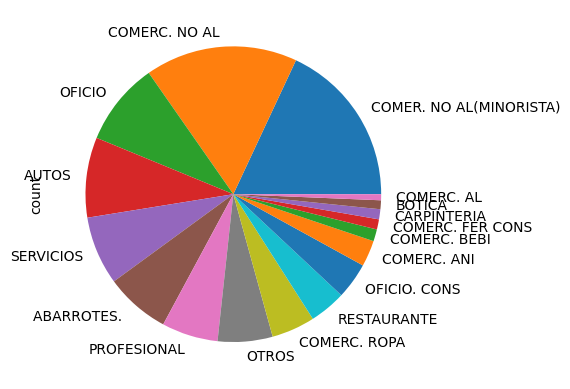

In [16]:
df['GIROS'].value_counts().plot(kind='pie')             #--- Grafica de pastel de los giros 

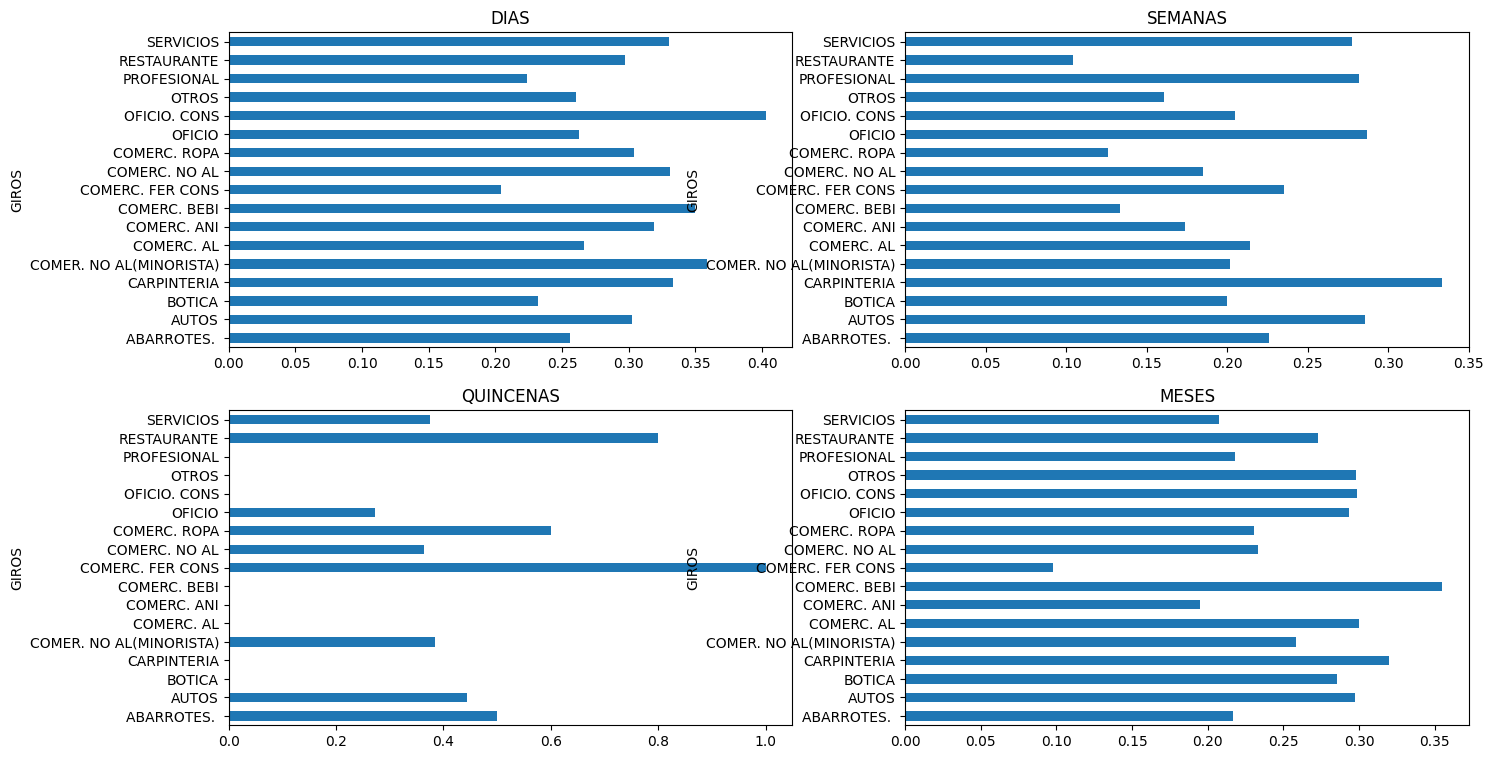

In [17]:
# Distribución de ocupaciones respecto a su Frecuencia de Pagos
mora = df.pivot_table(index='GIROS',columns='NOM_FRECUENCIA',values='MORA').sort_index()
fig,ax = plt.subplots(2,2,figsize=(16,9))
mora['DIAS '].plot(kind='barh',ax=ax[0,0])
ax[0, 0].set_title('DIAS')
mora['SEMANAS'].plot(kind='barh',ax=ax[0,1])
ax[0, 1].set_title('SEMANAS')
mora['QUINCENAS'].plot(kind='barh',ax=ax[1,0])
ax[1, 0].set_title('QUINCENAS')
mora['MESES'].plot(kind='barh',ax=ax[1,1])
ax[1, 1].set_title('MESES')
plt.show()